In [1]:
import json
import glob
from PIL import Image
from torchvision import datasets, transforms
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import os
import copy
from tqdm.notebook import tqdm
from skimage.draw import random_shapes
# from netCDF4 import Dataset as netDataset
import csv
import cartopy.crs as ccrs
import glob
import pickle
import random

import sys
sys.path.insert(1, '../Packages/data_dust_9_params')

from Dataset_dust_dataloader import * 
from Dataset_metadata import * 
from Channel import * 
from Dataset_tensors import * 
from Dataset_tensors_process import * 
from Dataset_nn_statistics import * 

# from data_dust_9_params.Dataset_dust import * 

# dir_path = os.path.dirname(os.path.realpath(__file__)) 

cuda_device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# # dir_path = os.path.dirname(os.path.realpath(__file__)) 
# p_channel = Channel("Z500", "Z at P=500 [hPa]", [(0,70,1), (-30,60,1)])
# pm_channel = Channel("pm", "PM10 count, daily averaged", ())
# channels = [p_channel, pm_channel]

In [2]:
# location = "local"
location = "chemfarm"

In [3]:
path_folder = "../Data/modules/era5" if location=="local" else "/work/dorini/dust_project/Data/modules/era5"

In [4]:
data_train = torch.load(path_folder+"/PVavg310to340_SLP_x0to40y20to60_2000to2015_PM_n0_X_train.pkl")
metadata_train = torch.load(path_folder+"/PVavg310to340_SLP_x0to40y20to60_2000to2015_PM_n0_metadata_train.pkl")
data_valid = torch.load(path_folder+"/PVavg310to340_SLP_x0to40y20to60_2000to2015_PM_n0_X_valid.pkl")
metadata_valid = torch.load(path_folder+"/PVavg310to340_SLP_x0to40y20to60_2000to2015_PM_n0_metadata_valid.pkl")

In [5]:
metadata_train.print_info()
metadata_valid.print_info()
data_train.shape, data_valid.shape

Data range: 15/06/2000,00:00 to 31/12/2015,12:00, total of 12757 points
Channels, idxs and sizes: [['pv', array([   0,    1,    2, ..., 6558, 6559, 6560]), 6561], ['slp', array([ 6561,  6562,  6563, ..., 13119, 13120, 13121]), 6561], ['pm', array([13122]), 1]]
Data range: 01/01/2002,00:00 to 31/12/2014,18:00, total of 6617 points
Channels, idxs and sizes: [['pv', array([   0,    1,    2, ..., 6558, 6559, 6560]), 6561], ['slp', array([ 6561,  6562,  6563, ..., 13119, 13120, 13121]), 6561], ['pm', array([13122]), 1]]


((13123, 12757), (13123, 6617))

In [18]:
default_idxs_pv = np.arange(6561)
default_idxs_slp = np.arange(6561,13122)
default_idxs_pm = 13122

In [19]:
# All pre-trained models expect input images normalized in the same way, 
# i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), 
# where H and W are expected to be at least 224. 
# The images have to be loaded in to a range of [0, 1] and then normalized using 
# mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

In [32]:
class CustomDataset(Dataset):
    def __init__(self, data, metadata, param="pv", img_size=224, idxs_pv=default_idxs_pv, 
                 idxs_slp=default_idxs_slp, idxs_pm=default_idxs_pm):
        self.param = param
        self.data = data.copy()
        self.img_size=img_size
        self.metadata = metadata
        self.idxs_pv = idxs_pv
        self.idxs_slp = idxs_slp
        self.idxs_pm = idxs_pm
        self.max_pv = self.data[idxs_pv,:].max()
        self.max_slp = self.data[idxs_slp-1,:].max()
        self.min_pv = self.data[idxs_pv,:].min()
        self.min_slp = self.data[idxs_slp,:].min()
        self.pm_mean = self.data[idxs_pm,:].mean()
        self.normalize_data_0_1_minmax()

    def __len__(self):
        return self.data.shape[1]
        
    def reshape_to_channels(self, x):
        # assuming the channels have the same sizes
        dim_lens = [self.metadata.channels_inputs[0].lens[0],self.metadata.channels_inputs[0].lens[1]]
        num_channels = len(self.metadata.channels_inputs)-1 # pm in the last channel in channels_inputs, TBD...
        return x.reshape(num_channels,dim_lens[0],dim_lens[1])
    
    def normalize_data_0_1_minmax(self):
        self.data[self.idxs_pv] = (self.data[self.idxs_pv,:]-self.min_pv)/(self.max_pv-self.min_pv)
        self.data[self.idxs_slp] = (self.data[self.idxs_slp,:]-self.min_slp)/(self.max_slp-self.min_slp)
    
    def batch_normalize_mean0std1(self,x):
        mean_batch,std_batch = x.mean(),x.std()
        x_normalized = (x-mean_batch)/std_batch
        return x_normalized
    
    def __getitem__(self, i):
        x = self.reshape_to_channels(self.data[:-1,i])
        print(x.shape)
        print(x.repeat(3,1,1).shape)
        x_img = Image.fromarray(x)
        x_img = transforms.Resize(self.img_size)(x_img)
        x = transforms.ToTensor()(x_img) #.repeat(3,1,1)
#         x_batch_normalized = self.batch_normalize_mean0std1(x)
        pm = torch.tensor([self.data[-1,i]],dtype=torch.double)
#         pm = pm - self.pm_mean
#         return x_batch_normalized, pm
        return x, pm


In [33]:
batches = 1 if torch.cuda.is_available() else 8
train_ds = CustomDataset(data_train,metadata_train)
valid_ds = CustomDataset(data_valid,metadata_valid)
dataloaders = {'train': DataLoader(train_ds, batch_size=batches, shuffle=True), 
               'valid': DataLoader(valid_ds, batch_size=batches, shuffle=True)}

In [34]:
x_sample_train, pm_sample_train = next(iter(dataloaders['train']))
x_sample_valid, pm_sample_valid = next(iter(dataloaders['valid']))

x_sample_train.shape, x_sample_valid.shape, pm_sample_train.shape


(2, 81, 81)


TypeError: repeat() takes at most 2 arguments (3 given)

In [9]:
# data_to_plot = x_sample_train[44,0,:,:]
# span = np.arange(81)
# plt.contourf(span,span,data_to_plot)

In [10]:
class Regressor_cnn(nn.Module):
    def __init__(self):
        super(Regressor_cnn, self).__init__()
        self.cnn = nn.Sequential(
            # [out] = 1+(W-K+2P)/S
            nn.Dropout(0.5),
            nn.Conv2d(2, 32, 3, padding=1, stride=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(32, 64, 3, padding=1, stride=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(64, 128, 3, padding=1, stride=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(128, 256, 3, padding=1, stride=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2, stride=2), 
#             nn.Conv2d(256, 512, 3, padding=1, stride=1),
#             nn.LeakyReLU(0.1),
#             nn.MaxPool2d(2, stride=2), 
        ).type(torch.double)
                       
        self.fc = nn.Sequential(
#             nn.Dropout(0.5),
            nn.Linear(6400,1000),
            nn.Tanh(),
#             nn.Linear(600,400),
#             nn.Tanh(),
            nn.Linear(1000,1),
#             nn.Tanh(),
#             nn.ReLU()
        ).type(torch.double)

    def forward(self, x):
        features = self.cnn(x).flatten(1)
#         print(features.shape)
        out = self.fc(features)
        return out

In [11]:
class Regressor_fc(nn.Module):
    def __init__(self):
        super(Regressor_fc, self).__init__()
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(13122,10000),
#             nn.Tanh(),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(10000,6000),
            nn.Tanh(),
#             nn.LeakyReLU(0.1),
            nn.Linear(6000,1),
#             nn.ReLU()
        ).type(torch.double)

    def forward(self, x):
        out = self.fc(x.flatten(1))
        return out

In [12]:
# weight initialization
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight,gain=20)
#         torch.nn.init.xavier_normal_(m.weight,gain=10)
#         m.bias.data.fill_(0.01)

In [13]:
net = Regressor_cnn()
net = net.to(cuda_device)
print("Regressor_cnn:")
print(net)

print("Testing sizes:")
x_samples, targets_sample = next(iter(dataloaders['train']))
x_samples.to(cuda_device)
targets_sample.to(cuda_device)
c1 = net(x_samples.to(cuda_device))
print(c1.shape)

Regressor_cnn:
Regressor_cnn(
  (cnn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.1)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.1)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=6400, out_features=1000, bias=True)
    (1): Tanh()
    (2): 

In [14]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, th1=73.4, th2=250, 
                weight1=1, weight2=1, debug_print=False, debug_plot=False, weight_regularization=1, epoch_plot=False):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000000000.0     
       
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode
            
            running_loss = 0.0           
            
            to_plot_epoch_outputs = True
            for inputs, targets in tqdm(dataloaders[phase]):
                inputs = inputs.to(cuda_device)
#                 inputs = batch_norm(inputs).to(cuda_device)

                targets = targets.to(cuda_device)
#                 labels = torch.where(targets>=th1, 
#                                               torch.tensor([1], dtype=torch.double).to(cuda_device), 
#                                               torch.tensor([0], dtype=torch.double).to(cuda_device) )        
#                 labels = torch.where(targets>=th2, 
#                                               torch.tensor([2], dtype=torch.double).to(cuda_device),
#                                               labels)
                optimizer.zero_grad() 
                with torch.set_grad_enabled(phase == 'train'): 
#                     print(inputs.shape)
                    outputs = model(inputs)
#                     _, predicts = torch.max(outputs[:,:3], 1)
#                     predicted_labels = torch.where(outputs>=th1, 
#                                                   torch.tensor([1], dtype=torch.double).to(cuda_device), 
#                                                   torch.tensor([0], dtype=torch.double).to(cuda_device) )        
#                     predicted_labels = torch.where(outputs>=th2, 
#                                                   torch.tensor([2], dtype=torch.double).to(cuda_device),
#                                                   predicted_labels )
                    

                    # Adjust high values
#                     outputs = outputs.double()
#                     targets = targets.double()
#                     outputs_adjusted = torch.where(outputs>=th1, 
#                                                   outputs*weight1, 
#                                                   outputs )        
#                     outputs_adjusted = torch.where(outputs_adjusted>=th2*weight2, 
#                                                   torch.tensor([th2*weight2], dtype=torch.double).to(cuda_device), 
#                                                   outputs_adjusted )        
#                     idxs_to_plot = np.arange(1000,1100,1)
#                     outputs_to_plot = outputs[:,0].cpu().detach().numpy()
#                     targets_to_plot = targets[:,0].cpu().detach().numpy()
#                     print("Before")
#                     plt.clf()
#                     plt.plot(np.arange(len(outputs_to_plot))[idxs_to_plot],outputs_to_plot[idxs_to_plot],
#                              np.arange(len(targets_to_plot))[idxs_to_plot],targets_to_plot[idxs_to_plot])
#                     plt.show()
#                     outputs = torch.where(outputs>=th1, 
#                                           outputs*weight1, 
#                                           outputs )              
#                     outputs = torch.where(outputs>=th2*weight1, 
#                                           outputs*weight2, 
#                                           outputs )              
#                     targets = torch.where(targets>=th1, 
#                                           targets*weight1, 
#                                           targets ) 
#                     targets = torch.where(targets>=th2*weight1, 
#                                           targets*weight2, 
#                                           targets )              

                    plot_len = min(10,outputs.shape[0])
                    plot_idxs = (0,10,1) 
                    to_plot = debug_plot

#                     idxs_to_plot = np.arange(plot_idxs[0],plot_idxs[1],plot_idxs[2])
#                     x_to_plot = np.arange(outputs.shape[0])
#                     outputs_to_plot = outputs[:,0].cpu().detach().numpy()
#                     targets_to_plot = targets[:,0].cpu().detach().numpy()
#                     plt.clf()
#                     plt.plot(x_to_plot[idxs_to_plot],outputs_to_plot[idxs_to_plot], label="output")
#                     plt.plot(x_to_plot[idxs_to_plot],targets_to_plot[idxs_to_plot], label="target")
#                     print("Debug - step 1")
#                     plt.legend()
#                     plt.show()
                      #########
                    outputs = Dataset_tensors_process.squared_weight_above_th_1d(
                        outputs, outputs, weight1, th1, to_plot=to_plot,plot_idxs=plot_idxs, device=cuda_device)
                    targets = Dataset_tensors_process.squared_weight_above_th_1d(
                        targets, targets, weight1, th1, to_plot=to_plot,plot_idxs=plot_idxs, device=cuda_device)   

                    outputs = Dataset_tensors_process.saturate_above_th_1d(
                        outputs,outputs,weight1*th2,to_plot=to_plot,plot_idxs=plot_idxs,device=cuda_device)
                    targets = Dataset_tensors_process.saturate_above_th_1d(
                        targets,targets,weight1*th2,to_plot=to_plot,plot_idxs=plot_idxs,device=cuda_device)

#                     outputs = weight2*outputs
#                     targets = weight2*targets
                      #########
#                     plt.clf()
#                     outputs_to_plot = outputs[:,0].cpu().detach().numpy()
#                     targets_to_plot = targets[:,0].cpu().detach().numpy()
#                     plt.plot(x_to_plot[idxs_to_plot],outputs_to_plot[idxs_to_plot], label="output")
#                     plt.plot(x_to_plot[idxs_to_plot],targets_to_plot[idxs_to_plot], label="target")
#                     print("Debug - step 2")
#                     plt.legend()
#                     plt.show()

                    loss = criterion(weight2*outputs,weight2*targets)

#                     loss = criterion(outputs,targets)
    
                    if phase == 'train':
                        loss.backward()
#                         debug_print = False
                        if epoch % 1 == 0 and debug_print:
                            print("Requires grad =", outputs.requires_grad)
                            param_idx = 1
                            debug_print = False
                            debug_params = list(model.regressor.parameters())
                            print("Grads:")
                            print(debug_params[0].grad[0,:6])
                            print(debug_params[0].grad_fn)
                            print("Weights:")
                            print(model.regressor[param_idx].weight[0,:6])
                            print(model.regressor[param_idx].weight.shape, model.regressor[param_idx].weight.max(),
                                  model.regressor[param_idx].weight.min())
                        if to_plot_epoch_outputs:
                            to_plot_epoch_outputs = False
                            outputs_plot_epoch = outputs.detach().cpu()[:,0].numpy()
                            targets_plot_epoch = targets.detach().cpu()[:,0].numpy()
                            x_plot_epoch = np.arange(outputs_plot_epoch.shape[0])
                            plt.plot(x_plot_epoch,outputs_plot_epoch,x_plot_epoch,targets_plot_epoch)
                            plt.show()
                        optimizer.step()
                        
                    

#               Weight regularization
                if weight_regularization != 0:
                    with torch.no_grad():
                        for param in model.parameters():
                            param.clamp_(-weight_regularization, weight_regularization)
                
                # statistics
                running_loss += loss.item()*outputs.shape[0]
                
#             if epoch_plot:
#                 Dataset_nn_statistics.print_statistics_3_classes(model, dataloaders[phase], cuda_device, 
#                                            phase='valid', print_type="long", th1=73.4,th2=150)
            if (epoch % 1 == 0) and (epoch % 50 != 0):
                Dataset_nn_statistics.print_statistics_3_classes(model, dataloaders[phase], cuda_device, 
                                           phase='valid', print_type="shortest", th1=73.4,th2=150)
            if (epoch % 50 == 0  or epoch == num_epochs-1):
                Dataset_nn_statistics.print_statistics_3_classes(model, dataloaders[phase], cuda_device, 
                                           phase='valid', print_type="short", th1=73.4,th2=150)
#             if (epoch % 100 == 0  or epoch == num_epochs-1):
#                 Dataset_nn.print_statistics_3_classes(model, dataloaders[phase], cuda_device, 
#                                            phase='valid', print_type="long", th1=73.4,th2=150)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            if phase == 'train':
                epochs_history.append(epoch)
                loss_history_train.append(epoch_loss)
            if phase == 'valid':
                loss_history_valid.append(epoch_loss)
           
            print('{} Loss: {:.8f}'.format(phase, epoch_loss))
            # deep copy the model
            if phase == 'valid' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
#             torch.save(model.state_dict(), '../Data/modules/tests1_daily_weighted/model2_temp.pt')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best epoch val Loss: {:.8f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)  
    model.eval()
    
#     print("Best validation-loss performance:")
#     Dataset_nn_statistics.print_statistics_3_classes(model, dataloaders[phase], cuda_device, 
#         phase='valid', print_type="long", th1=73.4,th2=150)        
    return model


Epoch 0/499
----------


  0%|          | 0/200 [00:00<?, ?it/s]

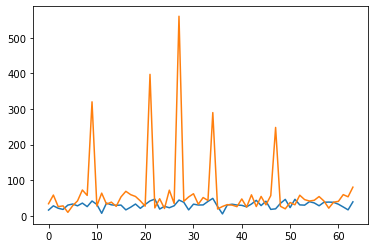

KeyboardInterrupt: 

In [15]:
loss_history_train = []
loss_history_valid = []
epochs_history = []

num_epochs = 500

net = Regressor_cnn()
# net = Regressor_fc()
net = net.to(cuda_device)
net.apply(init_weights)


# # t_weights=torch.tensor([1,3,6], dtype=torch.float).to(cuda_device)
# t_weights=torch.tensor([1,1], dtype=torch.float).to(cuda_device)
# criterion_labels = nn.CrossEntropyLoss(weight=t_weights)
# criterion_pm = torch.nn.SmoothL1Loss(reduction='mean')
# criterion = torch.nn.SmoothL1Loss(reduction='mean')
criterion = torch.nn.MSELoss(reduction='mean')
# net = net.to(torch.double)
# criterion = nn.BCEWithLogitsLoss()
lr_decay_step_size = 7


optimizer = optim.Adam(net.parameters(), lr=0.00000001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.00001, 
                       amsgrad=False)

# optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.999)
lr_sched = lr_scheduler.StepLR(optimizer, lr_decay_step_size, gamma=0.1)

# weight1=2.8, weight2=2

trained_model = train_model(net, dataloaders, criterion, optimizer, lr_sched, num_epochs=num_epochs, 
                            th1=73.4, th2=280, weight1=3.5, weight2=1, debug_print=False, debug_plot=False,
                            weight_regularization=0)


In [ ]:
plt.plot(epochs_history,loss_history_train,epochs_history,loss_history_valid)